In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [205]:
df = pd.read_csv("/Users/cartermain/Downloads/london_weather.csv")

In [206]:
print(df.head())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  


In [207]:
# checking null values by column
print(df.isnull().sum())

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


We need to make snow_depth 0 for days without preciptitation and days where the min temp over 5° where snow can't accumulate

In [210]:
# changing null snow_depth to 0 for rows where precipitation is 0
df.loc[(df["snow_depth"].isnull()) & (df["precipitation"] == 0), "snow_depth"] = 0

In [211]:
# changing null snow_depth to 0 for rows where the min temp was above the temp needed for snow to accumulate on ground (5° C)
df.loc[(df["snow_depth"].isnull()) & (df["min_temp"] > 5), "snow_depth"] = 0

In [213]:
print(df.isnull().sum())

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64


We're now at a point where null values make up an insignificant portion of dataset so we can drop

In [215]:
# dropping all null values
df.dropna(inplace = True)

Now that data is clean, let's dive in. First, we'll check the correlation between all columns

<AxesSubplot:>

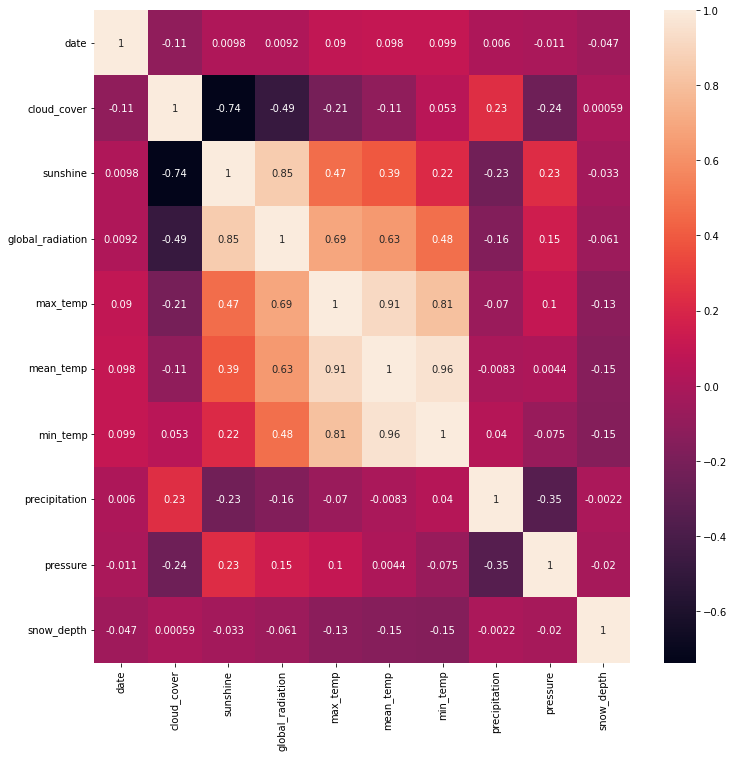

In [216]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr(), annot = True)

It looks like global radiation has an extremely strong correlation with sunshine. Let's dive into that further. 

In [217]:
print(df.corr()["sunshine"]["global_radiation"])

0.852884444008053


In [170]:
# taking a 30% sample of dataset to use for our regplot
sample_set = df.sample(frac = 0.3)

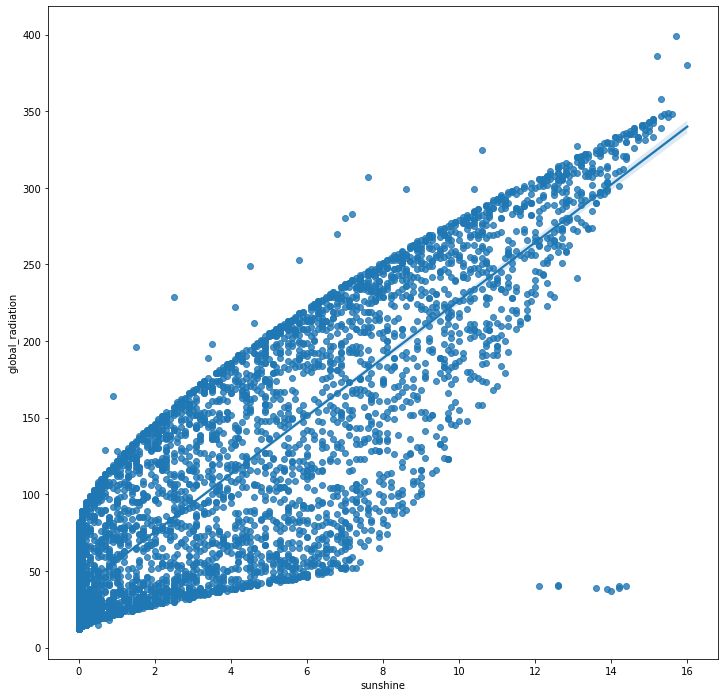

<Figure size 432x288 with 0 Axes>

In [218]:
# viewing regplot for a visual scatterplot representation with trendline
plt.figure(figsize = (12,12))
sns.regplot(x = sample_set["sunshine"], y = sample_set["global_radiation"], data = sample_set)
plt.show()
plt.clf()

We can see just how direct the correlation is visually with the help fo the regplot. Now, let's check the average temperature by decade to see if it has been increasing.

In [219]:
# creating new column to house date as datetime dtype
df["clean_date"] = pd.to_datetime(df["date"].astype(str), format = "%Y%m%d")

In [221]:
# extracting year from clean date as its own column
df["year"] = pd.DatetimeIndex(df["clean_date"]).year

In [222]:
# resetting index before next step as we will need clean indices for our loop
df = df.reset_index(drop=True)

In [223]:
# creating a decade column by looking at each value in the year column
for x in range(len(df)):
    if df["year"][x] < 1980:
        df.at[x, "decade"] = "1970's"
    elif df["year"][x] < 1990:
        df.at[x, "decade"] = "1980's"
    elif df["year"][x] < 2000:
        df.at[x, "decade"] = "1990's"
    elif df["year"][x] < 2010:
        df.at[x, "decade"] = "2000's"
    elif df["year"][x] < 2020:
        df.at[x, "decade"] = "2010's"
    else:
        df.at[x, "decade"] = "2020's"

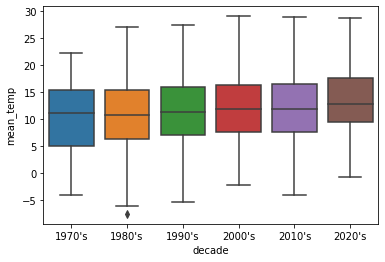

<Figure size 432x288 with 0 Axes>

In [224]:
# boxplotting mean temp by decade
sns.boxplot(x = df["decade"], y = df["mean_temp"], data = df)
plt.show()
plt.clf()

In [225]:
# getting a numerical representation of mean values to supplement boxplot above
print(round(df["mean_temp"].groupby(df["decade"]).mean(),2).sort_values(ascending = False))

decade
2020's    13.47
2010's    11.91
2000's    11.84
1990's    11.45
1980's    10.73
1970's    10.14
Name: mean_temp, dtype: float64


We see that the temperature was steadily increasing each decade. Now let's see what the chances of observing this at random would be.

In [226]:
# starting off by checking the pval via ANOVA test
fstat, pval = f_oneway(*(df["mean_temp"][df["decade"] == decade] for decade in df["decade"].unique()))
print(pval)

4.8999212650478427e-32


This is significant so let's use Tukey to find out which decades have a signficant different between them

In [227]:
# using Tukey's Range to find the pval for each decade comparison
tukey_results = pairwise_tukeyhsd(df["mean_temp"], df["decade"], 0.05)
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
1970's 1980's   0.5924 0.4216 -0.3111 1.4959  False
1970's 1990's   1.3105 0.0005  0.4069 2.2141   True
1970's 2000's   1.7032    0.0  0.7992 2.6071   True
1970's 2010's   1.7724    0.0  0.8687  2.676   True
1970's 2020's   3.3352   -0.0  2.0843 4.5861   True
1980's 1990's   0.7181    0.0  0.3379 1.0983   True
1980's 2000's   1.1108   -0.0  0.7297 1.4918   True
1980's 2010's     1.18   -0.0  0.7997 1.5602   True
1980's 2020's   2.7428   -0.0  1.7979 3.6877   True
1990's 2000's   0.3927 0.0392  0.0113  0.774   True
1990's 2010's   0.4619 0.0072  0.0813 0.8424   True
1990's 2020's   2.0247    0.0  1.0797 2.9697   True
2000's 2010's   0.0692 0.9955 -0.3122 0.4506  False
2000's 2020's    1.632    0.0  0.6867 2.5773   True
2010's 2020's   1.5628    0.0  0.6178 2.5078   True
---------------------------------------------------


There are only two decades for which we'd reject the null hypothesis which are between the 70's and 80's and 2000's and 2010's.

As a final, fun test let's find the hottest and coldest days within our dataset.

In [237]:
# returning clean_date and max_temp for hottest day and clean_date and min_temp for coldest day
print("Hottest day:")
print(df.loc[df["max_temp"].idxmax()][["clean_date", "max_temp"]])
# space
print("")
print("Coldest day: ")
print(df.loc[df["min_temp"].idxmin()][["clean_date", "min_temp"]])

Hottest day:
clean_date    2003-08-09 00:00:00
max_temp                     37.9
Name: 8958, dtype: object

Coldest day: 
clean_date    1981-12-13 00:00:00
min_temp                    -11.8
Name: 1065, dtype: object
